In [59]:
# !pip install scikit-learn
# !pip install matplotlib
# !pip install tqdm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.metrics import f1_score
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [2]:
with open('/Users/nalishjain/Acad Sem 6/NLP-Assignments/A4_16/train_dict.pkl', 'rb') as f:
    train_data = pickle.load(f, encoding='latin1')

with open('/Users/nalishjain/Acad Sem 6/NLP-Assignments/A4_16/val_dict.pkl', 'rb') as f:
    val_data = pickle.load(f, encoding='latin1')

emotion_ids = {'neutral' : 0, 'joy' : 1, 'anger' : 2, 'surprise' : 3, 'sadness' : 4, 'fear' : 5, 'disgust' : 6}

In [3]:
train_data[0][2]

['surprise', 'fear', 'surprise', 'sadness', 'disgust']

In [4]:
def pad_data():
    max_length = 25
    pad_word = 'PAD'
    pad_emotion = 'neutral'
    data = [train_data, val_data]
    dict_ = {}

    for task_data in data:
        remove_keys = []
        for key in task_data:
            if len(task_data[key][0]) not in dict_:
                dict_[len(task_data[key][0])] = 0
            dict_[len(task_data[key][0])] += 1
            # checking_nan
            for step in range(len(task_data[key][3])):
                if task_data[key][3][step] is None:
                    remove_keys.append(key)
                    print(key)
            for step in range(len(task_data[key][0]), max_length):
                task_data[key][0].append(pad_word)
                task_data[key][1].append(np.zeros(768))
                task_data[key][2].append(pad_emotion)
                task_data[key][3].append(0)
        
        for key in remove_keys:
            if key in task_data:
                del task_data[key] 
    # print(dict_)

pad_data()
train_data = {new_key: train_data[old_key] for new_key, (old_key, _) in enumerate(train_data.items())}
val_data = {new_key: val_data[old_key] for new_key, (old_key, _) in enumerate(val_data.items())}


492
628
676
1240
1308
1642
3257
3368
3764
4177
175
378
504
528


In [5]:
print(len(train_data))

4170


In [6]:
class GRUModel(nn.Module):
    def __init__(self, embedding_dim, output_size):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(embedding_dim, 256, num_layers=1, batch_first=True)
        self.gru2 = nn.GRU(256, 64, num_layers=1, batch_first=True)
        # self.gru3 = nn.GRU(128, 64, num_layers=1, batch_first=True)
        self.gru4 = nn.GRU(64, 16, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(16, 4)
        self.fc2 = nn.Linear(4, output_size)

    def forward(self, x):
        out, _ = self.gru1(x)
        out, _ = self.gru2(out)
        # out, _ = self.gru3(out)
        out, _ = self.gru4(out)
        out = self.fc1(out)   
        out = self.fc2(out)      
        return out
    

class ErfDataset(Dataset):
    def __init__(self, data, emo_index):
        self.data = data
        self.length = len(self.data)
        self.emo_index =  emo_index

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        sentence_embeddings = np.array(self.data[index][1] , dtype='float32')
        emotion_sequence = self.data[index][2]
        # print(emotion_sequence)
        emotion_labels = [self.emo_index[emotion] for emotion in emotion_sequence]
        output_labels = np.array(self.data[index][3], dtype='float32')
        return torch.tensor(sentence_embeddings, dtype= torch.float32), torch.tensor(emotion_labels, dtype= torch.float32), torch.tensor(output_labels, dtype= torch.float32)

In [7]:
train_data[0]

[['You-you\x85you had sex with Ursula?!',
  'Uh, a little bit. She-she-she walked in and I thought she was you and I kissed her and',
  "You didn't notice she was wearing different clothes?!",
  'Well I was just so excited to see you.',
  "Oh. Ew! Ew! Ew! Ugh! Y'know what? This is too weird.",
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 [array([-8.51336122e-01, -3.93138885e-01, -9.11756217e-01,  6.41342998e-01,
          6.20583177e-01, -2.10319817e-01,  6.72216296e-01,  2.65358418e-01,
         -7.70387053e-01, -9.99904990e-01, -1.70944408e-01,  8.94685984e-01,
          9.77414727e-01,  6.19037926e-01,  9.06642079e-01, -7.64781773e-01,
         -5.38599014e-01, -6.15865171e-01,  2.43284672e-01, -2.41211548e-01,
          5.98874390e-01,  9.99978662e-01,  1.95722394e-02,  1.56712174e-01,
          4.90767419e-01,  9.34231341e-01, -7.68067658e-01,  9

In [8]:
train_dataset = ErfDataset(train_data, emotion_ids)
val_dataset = ErfDataset(val_data, emotion_ids)

In [15]:
def train_model(train_dataset, val_dataset, model, optimizer, criterion, device,  num_epochs = 30, batch_size = 32):
    test_dataloader = None

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader =  DataLoader(val_dataset, batch_size=32, shuffle=True)
    print(len(train_dataloader))

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        all_train_predictions = []
        all_train_targets = []

        for batch_idx, (inputs, emotions, targets) in enumerate(train_dataloader):
            # print(batch_idx, "\\", len(train_dataloader))
            inputs, emotions, targets = inputs.to(device), emotions.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = 0

            for i in range(outputs.size(1)):  # Iterate over time steps
                # print(type(outputs[:, i, :]))
                loss += criterion(outputs[:, i, :], targets[:, i].long())  
            
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            all_train_predictions.extend(outputs.argmax(dim=2).view(-1).cpu().numpy())
            all_train_targets.extend(targets.view(-1).cpu().numpy())

        print(np.sum(np.array(all_train_predictions)), np.sum(np.array(all_train_targets)), len(all_train_targets))

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        # return all_train_targets
        train_macro_f1 = f1_score(all_train_targets, all_train_predictions, average='weighted')
        train_f1_scores.append(train_macro_f1)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Training Macro F1-Score: {train_macro_f1}")

        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        all_val_predictions = []
        all_val_targets = []

        with torch.no_grad():
            for val_inputs, val_emotions, val_targets in val_dataloader:
                val_inputs, val_emotions, val_targets = val_inputs.to(device), val_emotions.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)

                loss = 0
                for i in range(val_outputs.size(1)):  # Iterate over time steps
                    loss += criterion(val_outputs[:, i, :], val_targets[:, i].long())  

                total_val_loss += loss.item()

                all_val_predictions.extend(val_outputs.argmax(dim=2).view(-1).cpu().numpy())
                all_val_targets.extend(val_targets.view(-1).cpu().numpy())

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)

            val_macro_f1 = f1_score(all_val_targets, all_val_predictions, average='weighted')
            val_f1_scores.append(val_macro_f1)
        print(f"Epoch {epoch + 1},  Validation Loss: {avg_val_loss}, Validation Macro F1-Score: {val_macro_f1}")
    plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores)

    return train_losses, train_f1_scores, val_losses, val_f1_scores

def plot_results(train_losses, val_losses, train_f1_scores, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Macro F1-Scores
    # plt.subplot(1, 2, 2)
    # plt.plot(epochs, train_f1_scores, label='Training Macro F1-Score')
    # plt.plot(epochs, val_f1_scores, label='Validation Macro F1-Score')
    # plt.title('Training and Validation Macro F1-Scores')
    # plt.xlabel('Epochs')
    # plt.ylabel('Macro F1-Score')
    # plt.legend()

    # plt.tight_layout()
    plt.show()



# def test_model(task, embedding_type, model, criterion, device, batch_size = 1):
#     test_dataloader = None
#     if task == 1:
#         test_dataloader =  DataLoader(Task_data(task1_test_data, bio_mapping_task1, embedding_type), batch_size=batch_size, shuffle=False)

#     elif task == 2:
#         test_dataloader =  DataLoader(Task_data(task2_test_data, bio_mapping_task2, embedding_type), batch_size=batch_size, shuffle=False)

#     total_test_loss = 0
#     all_test_predictions = []
#     all_test_targets = []

#     with torch.no_grad():
#         for test_inputs, test_targets in test_dataloader:
#             test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
#             test_outputs = model(test_inputs)

#             loss = 0
#             for i in range(test_outputs.size(1)):  # Iterate over time steps
#                 loss += criterion(test_outputs[:, i, :], test_targets[:, i])  

#             total_test_loss += loss.item()

#             all_test_predictions.extend(test_outputs.argmax(dim=2).view(-1).cpu().numpy())
#             all_test_targets.extend(test_targets.view(-1).cpu().numpy())

#         avg_test_loss = total_test_loss / len(test_dataloader)
#         test_macro_f1 = f1_score(all_test_targets, all_test_predictions, average='macro')
#     print(f'Test Loss: {avg_test_loss}, Test Macro F1-Score: {test_macro_f1}')

131
30979 5738.0 104250
Epoch 1, Training Loss: 15.09377764927522, Training Macro F1-Score: 0.8172804840218416
Epoch 1,  Validation Loss: 13.385269568516659, Validation Macro F1-Score: 0.8151912926272096
31809 5738.0 104250
Epoch 2, Training Loss: 12.866646453624464, Training Macro F1-Score: 0.8151684401765612
Epoch 2,  Validation Loss: 12.444016163165752, Validation Macro F1-Score: 0.815050363303166
30135 5738.0 104250
Epoch 3, Training Loss: 11.93818669646751, Training Macro F1-Score: 0.8241683256728682
Epoch 3,  Validation Loss: 11.566332670358511, Validation Macro F1-Score: 0.8360126423734957
30000 5738.0 104250
Epoch 4, Training Loss: 11.146269448840892, Training Macro F1-Score: 0.8249083224669737
Epoch 4,  Validation Loss: 10.91609551356389, Validation Macro F1-Score: 0.8333350799964924
30918 5738.0 104250
Epoch 5, Training Loss: 10.527766249562038, Training Macro F1-Score: 0.8201995410448966
Epoch 5,  Validation Loss: 10.540740783397968, Validation Macro F1-Score: 0.816664395842

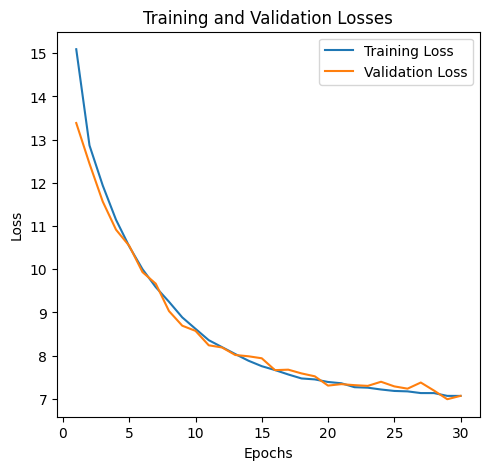

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GRUModel(768, 2).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.05,12.16]))
# criterion = nn.CrossEntropyLoss()

train_losses, train_f1_scores, val_losses, val_f1_scores = train_model(train_dataset, val_dataset, model = model, num_epochs = 30, optimizer=optimizer, criterion=criterion, batch_size=32, device=device)
# test_model(task = 1, embedding_type = "fast_text", model = model, criterion=criterion, device=device)
# targets = train_model(train_dataset, val_dataset, model = model, num_epochs = 30, optimizer=optimizer, criterion=criterion, batch_size=128, device=device)

# torch.save(model, 'trained_models/m3.pt')



In [17]:
torch.save(model.state_dict(), 'model_3_dict.pt')
